In [3]:
import pandas as pd

# Load the dataset from the uploaded file
file_path = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/latest_measurements_cleaned.csv'
data = pd.read_csv(file_path)

# Separate the first 10,000 rows
first_10k_rows = data.iloc[:10000]

# Save the first 10,000 rows to a new CSV
output_path = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/first_10k_rows.csv'
first_10k_rows.to_csv(output_path, index=False)

output_path


'/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/first_10k_rows.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training Progress: 100%|██████████| 250/250 [06:36<00:00,  1.58s/it]


Best Path Found:
Path ID: 7699
Entry FP: 3362524DF21DE2CCDCAE4B390CBBF0209040D5DC
Middle FP: CBCC85F335E20705F791CFC8685951C90E24134D
Exit FP: 16A8740ECC9785A650876F26A97425C6D8912625
Mean Latency: 812.75 ms


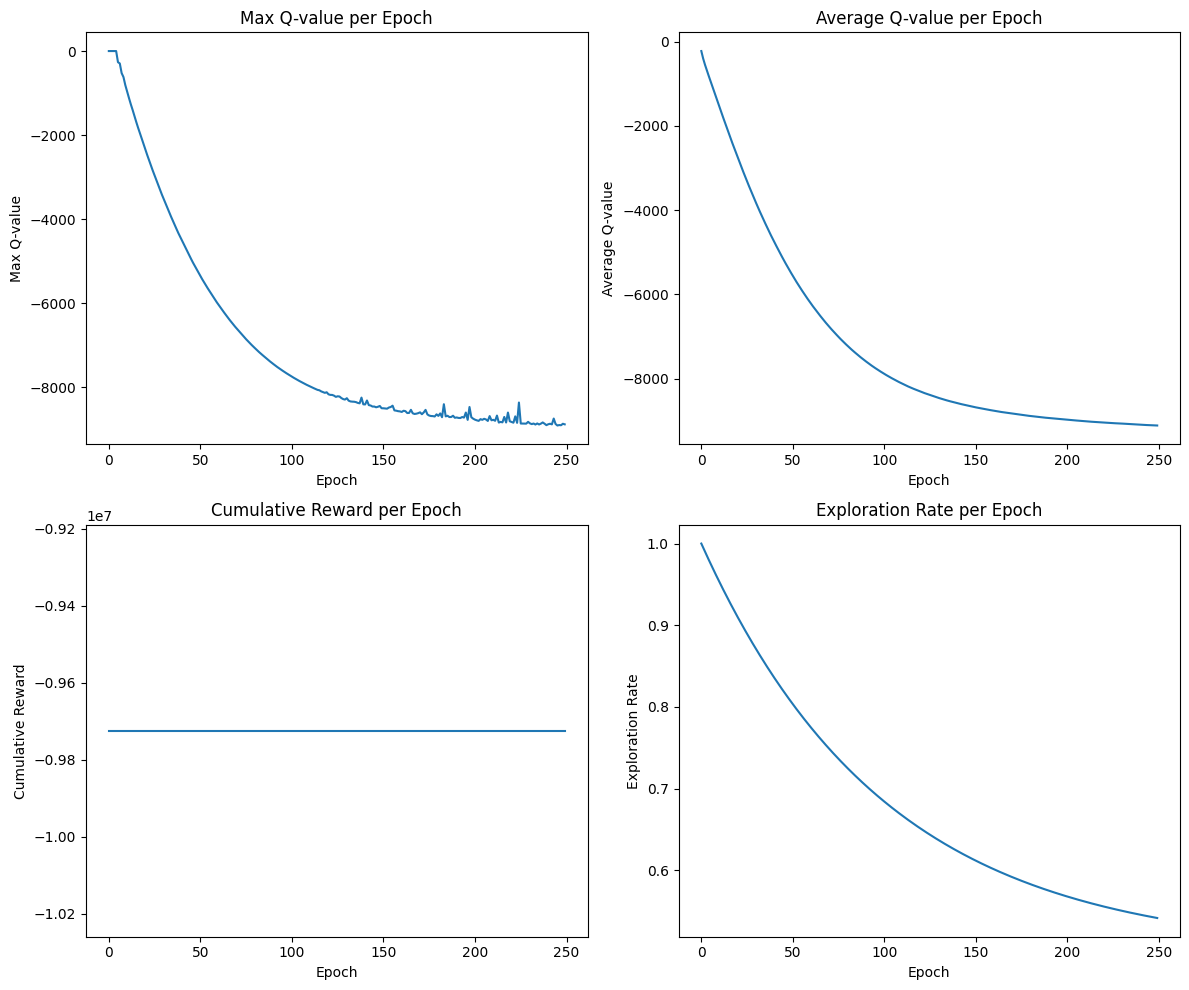

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pyarrow.parquet as pq
import pyarrow as pa

'''
This is just going to be a one state multiple action q-learning. One state
being that the latencies are representing one point in time. Actions are
all possile relay option combinations. Each combination is called a circuit.

Before using this program, randomly draw 10k samples from the
latest_measurements_cleaned.csv file. and save it to 10k_samples.csv file.
Make sure they are in the same folder with this program. Then run this program.

One thing to note for this q-learning is that this program is not looking for
the best(fastest) circuit. Because always using the fastest circuit will make
Tor users stick with one single circuit and repeatedly using it. This will
decreas the anonimity and will cause relay getting overloaded with traffics.
Instead, we are looking for a relatively faster circuit, meaning that each
time the q-learning yields a different circuit, which provides some level of
randomness.

'''

# Load the 10k dataset
csv_file = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/10k_samples.csv'
parquet_file = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/10k_samples.parquet'

# Use following file if for the 300k dataset
# csv_file = 'latest_measurements_cleaned.csv'
# parquet_file = 'latest_measurements_cleaned.parquet'

# Read the CSV file
df = pd.read_csv(csv_file)

# Save to Parquet
table = pa.Table.from_pandas(df)
pq.write_table(table, parquet_file)

# Read from Parquet for faster processing
df = pd.read_parquet(parquet_file)

# Extract unique fingerprints
entry_fps = df['entry_fp'].unique()
middle_fps = df['middle_fp'].unique()
exit_fps = df['exit_fp'].unique()

# Create mappings from fingerprints to indices
entry_fp_to_idx = {fp: idx for idx, fp in enumerate(entry_fps)}
middle_fp_to_idx = {fp: idx for idx, fp in enumerate(middle_fps)}
exit_fp_to_idx = {fp: idx for idx, fp in enumerate(exit_fps)}

# Define state and action spaces
num_entry = len(entry_fps)
num_middle = len(middle_fps)
num_exit = len(exit_fps)

# Initialize Q-table
Q_table = np.zeros((num_entry, num_middle, num_exit))

# Hyperparameters
num_epochs = 250
learning_rate = 0.35 #alpha
discount_factor = 0.9 #gamma
exploration_rate = 0.75 #epsilon
max_exploration_rate = 1.0
min_exploration_rate = 0.5
exploration_decay_rate = 0.01

# Lists to store metrics for plotting
max_q_values = []
avg_q_values = []
cumulative_rewards = []
exploration_rates = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    cumulative_reward = 0
    for index, row in df.iterrows():
        # Map fingerprints to indices
        entry_idx = entry_fp_to_idx[row['entry_fp']]
        middle_idx = middle_fp_to_idx[row['middle_fp']]
        exit_idx = exit_fp_to_idx[row['exit_fp']]

        # Exploration vs. Exploitation
        if np.random.uniform(0, 1) < exploration_rate:
            # Explore: select random actions
            entry_action = np.random.randint(0, num_entry)
            middle_action = np.random.randint(0, num_middle)
            exit_action = np.random.randint(0, num_exit)
        else:
            # Exploit: select the best action
            state_actions = Q_table[entry_idx]
            entry_action = np.argmax(np.max(np.max(Q_table, axis=2), axis=1))
            middle_action = np.argmax(np.max(Q_table[entry_action], axis=1))
            exit_action = np.argmax(Q_table[entry_action, middle_action])

        # Get the reward (negative latency since lower is better)
        reward = -row['mean']

        # Update Q-table
        old_value = Q_table[entry_action, middle_action, exit_action]
        next_max = np.max(Q_table[entry_action, middle_action, :])

        new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_factor * next_max)
        Q_table[entry_action, middle_action, exit_action] = new_value

        cumulative_reward += reward

    # Decay exploration rate
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * epoch)

    # Store metrics
    max_q_values.append(np.max(Q_table))
    avg_q_values.append(np.mean(Q_table))
    cumulative_rewards.append(cumulative_reward)
    exploration_rates.append(exploration_rate)

# Find the best path
best_entry_idx, best_middle_idx, best_exit_idx = np.unravel_index(np.argmax(Q_table), Q_table.shape)
best_entry_fp = entry_fps[best_entry_idx]
best_middle_fp = middle_fps[best_middle_idx]
best_exit_fp = exit_fps[best_exit_idx]

# Find the corresponding path_id and mean
best_row = df[(df['entry_fp'] == best_entry_fp) &
              (df['middle_fp'] == best_middle_fp) &
              (df['exit_fp'] == best_exit_fp)].iloc[0]

print("Best Path Found:")
print(f"Path ID: {best_row['path_id']}")
print(f"Entry FP: {best_entry_fp}")
print(f"Middle FP: {best_middle_fp}")
print(f"Exit FP: {best_exit_fp}")
print(f"Mean Latency: {best_row['mean']} ms")
#print(f"q_table: {Q_table}")

def four_in_one():
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Max Q-value per epoch
    axs[0, 0].plot(max_q_values)
    axs[0, 0].set_title('Max Q-value per Epoch')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Max Q-value')

    # Average Q-value per epoch
    axs[0, 1].plot(avg_q_values)
    axs[0, 1].set_title('Average Q-value per Epoch')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Average Q-value')

    # Cumulative reward per epoch
    axs[1, 0].plot(cumulative_rewards)
    axs[1, 0].set_title('Cumulative Reward per Epoch')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Cumulative Reward')

    # Exploration rate per epoch
    axs[1, 1].plot(exploration_rates)
    axs[1, 1].set_title('Exploration Rate per Epoch')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Exploration Rate')

    plt.tight_layout()
    plt.savefig('chatgpt_plot.pdf')
    plt.show()

# Plotting and saving each plot individually
def four_plots():
    # Max Q-value per epoch
    plt.figure()
    plt.plot(max_q_values)
    plt.title('Max Q-value per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Max Q-value')
    plt.tight_layout()
    plt.savefig('max_q_value_per_epoch.pdf')
    plt.show(block=False)

    # Average Q-value per epoch
    plt.figure()
    plt.plot(avg_q_values)
    plt.title('Average Q-value per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Q-value')
    plt.tight_layout()
    plt.savefig('avg_q_value_per_epoch.pdf')
    plt.show(block=False)

    # Cumulative reward per epoch
    plt.figure()
    plt.plot(cumulative_rewards)
    plt.title('Cumulative Reward per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Reward')
    plt.tight_layout()
    plt.savefig('cumulative_reward_per_epoch.pdf')
    plt.show(block=False)

    # Exploration rate per epoch
    plt.figure()
    plt.plot(exploration_rates)
    plt.title('Exploration Rate per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Exploration Rate')
    plt.tight_layout()
    plt.savefig('exploration_rate_per_epoch.pdf')
    plt.show()

plot_flag = True

if plot_flag == False:
    four_plots()
else:
    four_in_one()

Training Progress: 100%|██████████| 250/250 [5:36:56<00:00, 80.87s/it] 


Best Path Found:
Path ID: 388768
Entry FP: 772ACD8767F3D24312416FAF2ADB70E6ABA7CB3D
Middle FP: 7AA59A8A5450A1DB584DFABE20D328EA616FE247
Exit FP: 555A6B7CB3D8ECA376B4CB6701596A7B211E21D3
Mean Latency: 910.2 ms


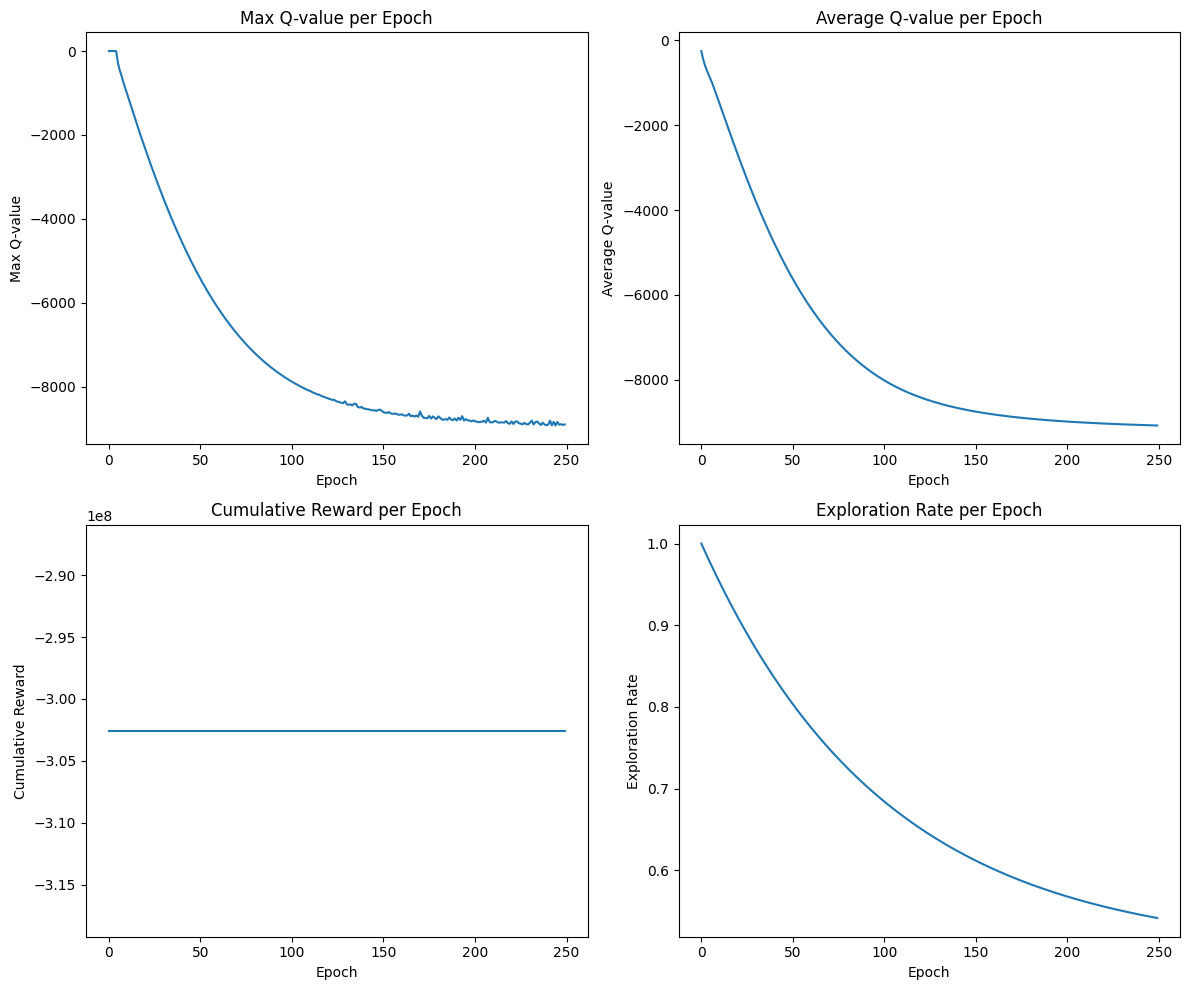

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pyarrow.parquet as pq
import pyarrow as pa

'''
This is just going to be a one state multiple action q-learning. One state
being that the latencies are representing one point in time. Actions are
all possible relay option combinations. Each combination is called a circuit.

Before using this program, randomly draw 10k samples from the
latest_measurements_cleaned.csv file. and save it to 10k_samples.csv file.
Make sure they are in the same folder with this program. Then run this program.

One thing to note for this q-learning is that this program is not looking for
the best(fastest) circuit. Because always using the fastest circuit will make
Tor users stick with one single circuit and repeatedly using it. This will
decrease the anonymity and will cause relay getting overloaded with traffic.
Instead, we are looking for a relatively faster circuit, meaning that each
time the q-learning yields a different circuit, which provides some level of
randomness.

'''

# Load the 10k dataset
#csv_file = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/10k_samples.csv'
#parquet_file = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/10k_samples.parquet'

# Use following file if for the 300k dataset
csv_file = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/latest_measurements_cleaned.csv'
parquet_file = '/content/drive/MyDrive/UCCS New Research/Quick-Tor Project/latest_measurements_cleaned.parquet'

# Read the CSV file
df = pd.read_csv(csv_file)

# Save to Parquet
table = pa.Table.from_pandas(df)
pq.write_table(table, parquet_file)

# Read from Parquet for faster processing
df = pd.read_parquet(parquet_file)

# Extract unique fingerprints
entry_fps = df['entry_fp'].unique()
middle_fps = df['middle_fp'].unique()
exit_fps = df['exit_fp'].unique()

# Create mappings from fingerprints to indices
entry_fp_to_idx = {fp: idx for idx, fp in enumerate(entry_fps)}
middle_fp_to_idx = {fp: idx for idx, fp in enumerate(middle_fps)}
exit_fp_to_idx = {fp: idx for idx, fp in enumerate(exit_fps)}

# Define state and action spaces
num_entry = len(entry_fps)
num_middle = len(middle_fps)
num_exit = len(exit_fps)

# Initialize Q-table
Q_table = np.zeros((num_entry, num_middle, num_exit))

# Hyperparameters
num_epochs = 250
learning_rate = 0.35  # alpha
discount_factor = 0.9  # gamma
exploration_rate = 0.75  # epsilon
max_exploration_rate = 1.0
min_exploration_rate = 0.5
exploration_decay_rate = 0.01

# Lists to store metrics for plotting
max_q_values = []
avg_q_values = []
cumulative_rewards = []
exploration_rates = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    cumulative_reward = 0
    for index, row in df.iterrows():
        # Map fingerprints to indices
        entry_idx = entry_fp_to_idx[row['entry_fp']]
        middle_idx = middle_fp_to_idx[row['middle_fp']]
        exit_idx = exit_fp_to_idx[row['exit_fp']]

        # Exploration vs. Exploitation
        if np.random.uniform(0, 1) < exploration_rate:
            # Explore: select random actions
            entry_action = np.random.randint(0, num_entry)
            middle_action = np.random.randint(0, num_middle)
            exit_action = np.random.randint(0, num_exit)
        else:
            # Exploit: select the best action
            state_actions = Q_table[entry_idx]
            entry_action = np.argmax(np.max(np.max(Q_table, axis=2), axis=1))
            middle_action = np.argmax(np.max(Q_table[entry_action], axis=1))
            exit_action = np.argmax(Q_table[entry_action, middle_action])

        # Get the reward (negative latency since lower is better)
        reward = -row['mean']

        # Update Q-table
        old_value = Q_table[entry_action, middle_action, exit_action]
        next_max = np.max(Q_table[entry_action, middle_action, :])

        new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_factor * next_max)
        Q_table[entry_action, middle_action, exit_action] = new_value

        cumulative_reward += reward

    # Decay exploration rate
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * epoch)

    # Store metrics
    max_q_values.append(np.max(Q_table))
    avg_q_values.append(np.mean(Q_table))
    cumulative_rewards.append(cumulative_reward)
    exploration_rates.append(exploration_rate)

# Find the best path
best_entry_idx, best_middle_idx, best_exit_idx = np.unravel_index(np.argmax(Q_table), Q_table.shape)
best_entry_fp = entry_fps[best_entry_idx]
best_middle_fp = middle_fps[best_middle_idx]
best_exit_fp = exit_fps[best_exit_idx]

# Find the corresponding path_id and mean
best_row = df[(df['entry_fp'] == best_entry_fp) &
              (df['middle_fp'] == best_middle_fp) &
              (df['exit_fp'] == best_exit_fp)].iloc[0]

print("Best Path Found:")
print(f"Path ID: {best_row['path_id']}")
print(f"Entry FP: {best_entry_fp}")
print(f"Middle FP: {best_middle_fp}")
print(f"Exit FP: {best_exit_fp}")
print(f"Mean Latency: {best_row['mean']} ms")

def four_in_one():
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Max Q-value per epoch
    axs[0, 0].plot(max_q_values)
    axs[0, 0].set_title('Max Q-value per Epoch')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Max Q-value')

    # Average Q-value per epoch
    axs[0, 1].plot(avg_q_values)
    axs[0, 1].set_title('Average Q-value per Epoch')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Average Q-value')

    # Cumulative reward per epoch
    axs[1, 0].plot(cumulative_rewards)
    axs[1, 0].set_title('Cumulative Reward per Epoch')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Cumulative Reward')

    # Exploration rate per epoch
    axs[1, 1].plot(exploration_rates)
    axs[1, 1].set_title('Exploration Rate per Epoch')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Exploration Rate')

    plt.tight_layout()
    plt.savefig('chatgpt_plot.pdf')
    plt.show()

# Plotting and saving each plot individually
def four_plots():
    # Max Q-value per epoch
    plt.figure()
    plt.plot(max_q_values)
    plt.title('Max Q-value per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Max Q-value')
    plt.tight_layout()
    plt.savefig('max_q_value_per_epoch.pdf')
    plt.show(block=False)

    # Average Q-value per epoch
    plt.figure()
    plt.plot(avg_q_values)
    plt.title('Average Q-value per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Q-value')
    plt.tight_layout()
    plt.savefig('avg_q_value_per_epoch.pdf')
    plt.show(block=False)

    # Cumulative reward per epoch
    plt.figure()
    plt.plot(cumulative_rewards)
    plt.title('Cumulative Reward per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Reward')
    plt.tight_layout()
    plt.savefig('cumulative_reward_per_epoch.pdf')
    plt.show(block=False)

    # Exploration rate per epoch
    plt.figure()
    plt.plot(exploration_rates)
    plt.title('Exploration Rate per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Exploration Rate')
    plt.tight_layout()
    plt.savefig('exploration_rate_per_epoch.pdf')
    plt.show()

plot_flag = True

if plot_flag == False:
    four_plots()
else:
    four_in_one()
